In [1]:
import os
import pickle
import numpy as np
import torch

from scipy.io import loadmat
from PIL import Image

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

DEVICE = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
print(DEVICE)

0
1
Tesla P100-PCIE-16GB
0


In [2]:
os.environ['HOME'] = '/kaggle/input/pden-digit-data'
HOME = os.environ['HOME']

with open(os.path.join(HOME, 'mnist-test.pkl'), 'rb') as f:
    mnist_img, mnist_label = pickle.load(f)

with open(os.path.join(HOME, 'mnist_m-test.pkl'), 'rb') as f:
    mnistm_img, mnistm_label = pickle.load(f)

with open(os.path.join(HOME, 'usps-test.pkl'), 'rb') as f:
    usps_img, usps_label = pickle.load(f)
    
data = loadmat(os.path.join(HOME, 'svhn_test_32x32.mat'))
svhn_img, svhn_label = data['X'], data['y']
svhn_img = np.transpose(svhn_img, [3, 2, 0, 1]).astype('float32')/255.
svhn_label = svhn_label.squeeze()

data = loadmat(os.path.join(HOME, 'synth_test_32x32.mat'))
synth_img, synth_label = data['X'], data['y']
synth_img = np.transpose(synth_img, [3, 2, 0, 1]).astype('float32')/255.
synth_label = synth_label.squeeze()

print(mnist_img.shape, type(mnist_img), type(mnist_label))
print(mnistm_img.shape, type(mnistm_img), type(mnistm_label))
print(usps_img.shape, type(usps_img), type(usps_label))
print(svhn_img.shape, type(svhn_img), type(svhn_label))
print(synth_img.shape, type(synth_img), type(synth_label))

torch.Size([10000, 3, 32, 32]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([9001, 3, 32, 32]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([2007, 3, 32, 32]) <class 'torch.Tensor'> <class 'torch.Tensor'>
(26032, 3, 32, 32) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(9553, 3, 32, 32) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


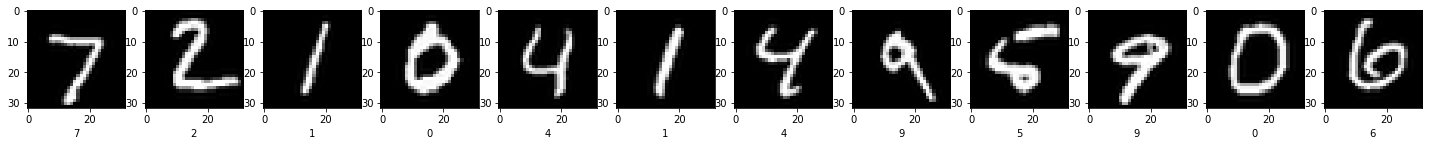

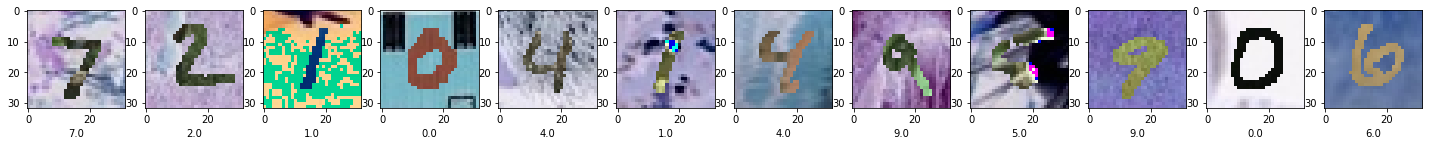

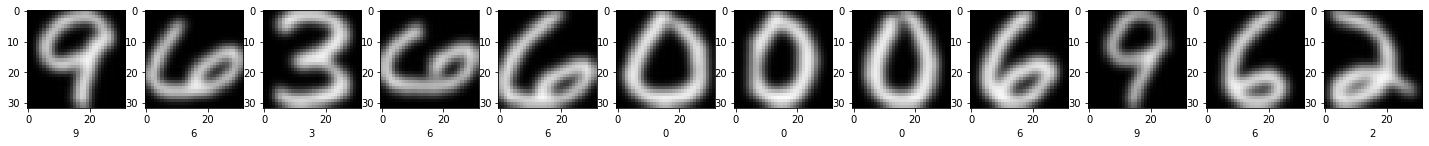

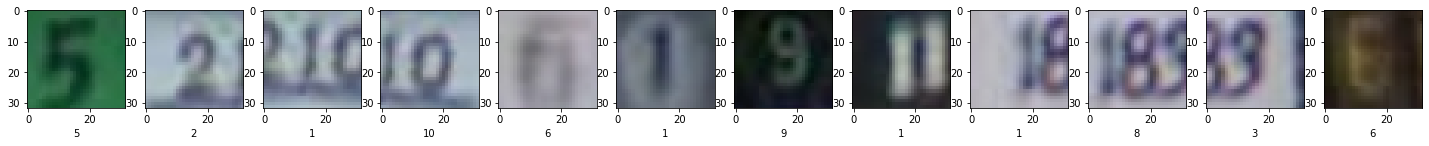

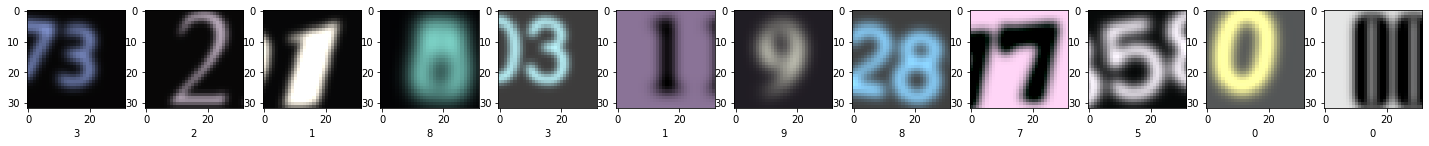

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as visionF

def imgshow(imgs, labels):
    if torch.is_tensor(labels):
        labels = labels.numpy()
        
    fig, axs = plt.subplots(ncols=imgs.size(0), nrows=1, squeeze=False, figsize=(25, 10))
    for i in range(imgs.size(0)):
        img = imgs[i];
        #if torch.is_tensor(img):
            #img = img.detach()
        img = visionF.to_pil_image(img)
        axs[0, i].imshow(img)
        axs[0, i].set_xlabel(labels[i])
        
imgshow(mnist_img[0:12], mnist_label[0:12])
imgshow(mnistm_img[0:12], mnistm_label[0:12])
imgshow(usps_img[0:12], usps_label[0:12])
imgshow(torch.Tensor(svhn_img[0:12]), svhn_label[0:12])
imgshow(torch.Tensor(synth_img[0:12]), synth_label[0:12])

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torchvision import transforms

def resize_imgs(x, size):
    # x[n, 28, 28]
    resize_x = np.zeros([x.shape[0], size, size])
    for i, im in enumerate(x):
        im = Image.fromarray(im)
        im = im.resize([size, size], Image.ANTIALIAS)
        resize_x[i] = np.asarray(im)
    return resize_x

def load_mnist(split='train', channels=3):
    path = f'mnist-{split}.pkl'
    with open(os.path.join(HOME, path), 'rb') as f:
        x, y = pickle.load(f)
    
    if torch.max(x) > 1.0:
        x = x/255
        
    dataset = TensorDataset(x, y)
    return dataset

def load_mnist_m(split='train', channels=3):
    path = f'mnist_m-{split}.pkl'
    with open(os.path.join(HOME, path), 'rb') as f:
        x, y = pickle.load(f)
    
    if torch.max(x) > 1.0:
        x = x/255
        
    dataset = TensorDataset(x, y)
    return dataset

def load_usps(split='train', channels=3):
    path = f'usps-{split}.pkl'
    with open(os.path.join(HOME, path), 'rb') as f:
        x, y = pickle.load(f)
    
    if torch.max(x) > 1.0:
        x = x/255
        
    dataset = TensorDataset(x, y)
    return dataset

def load_svhn(split='train', channels=3):
    path = f'svhn_{split}_32x32.mat'
    data = loadmat(os.path.join(HOME, path))
    data['X'] = np.transpose(data['X'], [3, 2, 0, 1])
    x, y = [], []
    for fst, snd in zip(data['X'], data['y']):
        if snd[0] > 9:
            continue
        x.append(fst)
        y.append(snd[0])
        
    x, y = np.asarray(x), np.asarray(y)
    #print(x.shape, y.shape)
    y = y.squeeze()
    x, y = torch.tensor(x), torch.tensor(y)
    if torch.max(x) > 1.0:
        x = x.type(torch.float32) / 255.0
        
    dataset = TensorDataset(x, y)
    return dataset

def load_syndigit(split='test', channels=3):
    path = f'synth_{split}_32x32.mat'
    print(data['X'].shape)
    data['X'] = np.transpose(data['X'], [3, 2, 0, 1])
    x, y = [], []
    for fst, snd in zip(data['X'], data['y']):
        if snd[0] > 9:
            continue
        x.append(fst)
        y.append(snd[0])
        
    x, y = np.asarray(x), np.asarray(y)
    #print(x.shape, y.shape)
    y = y.squeeze()
    x, y = torch.tensor(x), torch.tensor(y)
    if torch.max(x) > 1.0:
        x = x.type(torch.float32) / 255.0
    
    dataset = TensorDataset(x, y)
    return dataset

mapfunc = {
    'mnist': load_mnist,
    #'mnist_m': load_mnist_m,
    'usps': load_usps,
    #'svhn': load_svhn
    #'syndigit': load_syndigit
}

In [5]:
class ConvNet(torch.nn.Module):
    def __init__(self, indim=3):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(indim, 64, kernel_size=5, stride=1, padding=0)
        self.mp = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128,kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128*5*5, 1024)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 1024)
        self.relu4 = nn.ReLU(inplace=True)
        
        self.cls_head_src = nn.Linear(1024, 10)
        self.cls_head_tgt = nn.Linear(1024, 10)
        self.pro_head = nn.Linear(1024, 128)
        
    def forward(self, x, mode='test'):
        in_size = x.size(0)
        out1 = self.mp(self.relu1(self.conv1(x)))
        out2 = self.mp(self.relu2(self.conv2(out1)))
        out2 = out2.view(in_size, -1)
        out3 = self.relu3(self.fc1(out2))
        out4 = self.relu4(self.fc2(out3))
        
        if mode == 'test':
            p = self.cls_head_src(out4)
            return p
        elif mode == 'train':
            p = self.cls_head_src(out4)
            z = self.cls_head(out4)
            z = F.normalize(z)
            return p,z

In [6]:
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

import time
import matplotlib.pyplot as plt

def evaluate(model, name_test, batch_size=32):
    test_set = mapfunc[name_test](split='test')
    test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=8, shuffle=False)
    
    correct_count = 0, 0
    ps = []
    ys = []
    for i,(x1, y1) in enumerate(test_loader):
        with torch.no_grad():
            x1 = x1.cuda()
            p1 = model(x1)
            p1 = p1.argmax(dim=1)
            ps.append(p1.detach().cpu().numpy())
            ys.append(y1.numpy())
    
    ps = np.concatenate(ps)
    ys = np.concatenate(ys)
    acc = np.mean(ys == ps)*100
    return acc
    
def train_task_model(model, data=None, name='mnist', epochs = 30, batch_size=256, lr=1e-3, save_root='/kaggle/woring'):
    if data is None:
        train_set = mapfunc[name](split='train')
    else: train_set = data
    
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=8, shuffle=True)
    
    cls_opt = optim.Adam(model.parameters(), lr=lr)
    
    cls_criterion = nn.CrossEntropyLoss()
    
    best_acc = 0
    loss_hist = []
    model.to(DEVICE)
    for epoch in range(epochs):
        t1 = time.time()
        
        loss_list = []
        model.train()
        for i, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()
            
            p = model(x)
            cls_loss = cls_criterion(p, y)
            cls_opt.zero_grad()
            cls_loss.backward()
            cls_opt.step()
            
            loss_list.append(cls_loss.item())
    
        cls_loss = np.mean(loss_list)
        loss_hist.append(cls_loss)
        
        model.eval()
        test_acc = evaluate(model, name, batch_size)
        
        t2 = time.time()
        print(f'epoch {epoch}, time {t2-t1:.2f}, cls_loss {cls_loss:.4f}, train_acc: {test_acc:2.2f}')
    
    plt.plot(np.array(loss_hist), 'b')

In [7]:
import pandas as pd

def evaluate_digit(cls_net, name_test='mnist'):
    columns = list(mapfunc.keys())
    rst = []
    for data in columns:
        test_acc = evaluate(cls_net, data)
        rst.append(test_acc)

    plt.figure(figsize=(6, 6))
    plt.bar(columns, rst)
    df = pd.DataFrame([rst], columns=columns)
    print(df)
    plt.show()

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0, time 7.80, cls_loss 0.6525, train_acc: 95.05
epoch 1, time 1.98, cls_loss 0.1178, train_acc: 96.80
epoch 2, time 2.02, cls_loss 0.0607, train_acc: 97.75
epoch 3, time 2.09, cls_loss 0.0417, train_acc: 97.01
epoch 4, time 1.98, cls_loss 0.0434, train_acc: 98.19
epoch 5, time 2.19, cls_loss 0.0167, train_acc: 98.28
epoch 6, time 1.98, cls_loss 0.0097, train_acc: 98.44
epoch 7, time 2.00, cls_loss 0.0074, train_acc: 98.40
epoch 8, time 2.38, cls_loss 0.0208, train_acc: 98.06
epoch 9, time 1.98, cls_loss 0.0108, train_acc: 98.56
epoch 10, time 2.15, cls_loss 0.0039, train_acc: 98.47
epoch 11, time 2.09, cls_loss 0.0048, train_acc: 98.47
epoch 12, time 2.13, cls_loss 0.0021, train_acc: 98.53
epoch 13, time 2.00, cls_loss 0.0006, train_acc: 98.70
epoch 14, time 1.99, cls_loss 0.0003, train_acc: 98.65
epoch 15, time 2.00, cls_loss 0.0019, train_acc: 98.47
epoch 16, time 2.23, cls_loss 0.0081, train_acc: 98.20
epoch 17, time 2.03, cls_loss 0.0134, train_acc: 98.24
epoch 18, time 1.99,

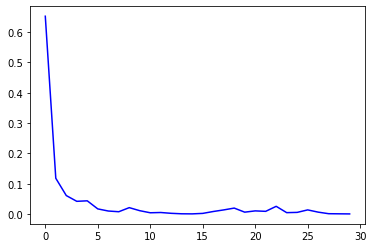

In [8]:
cls_net = ConvNet()
train_task_model(cls_net, name='mnist')

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


   mnist       usps
0  98.79  76.183358


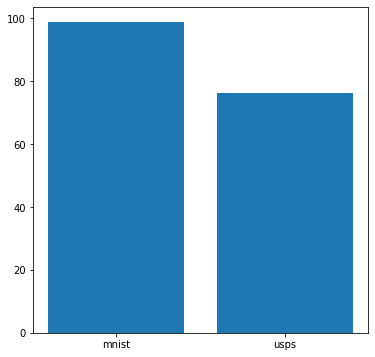

In [9]:
evaluate_digit(cls_net, name_test='mnist')

In [10]:
class VAE(torch.nn.Module):
    def __init__(self, latent_dim = 3):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.enc_conv2d_1 = torch.nn.Conv2d(3, 32, kernel_size=(3, 3))
        self.enc_relu_1 = torch.nn.LeakyReLU(0.)
        self.enc_conv2d_2 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.enc_relu_2 = torch.nn.LeakyReLU(0.)
        self.enc_conv2d_3 = torch.nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.enc_relu_3 = torch.nn.LeakyReLU(0.)
        self.enc_conv2d_4 = torch.nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.enc_relu_4 = torch.nn.LeakyReLU(0.)
        self.enc_flatten = torch.nn.Flatten()
        
        self.z_mu = torch.nn.Linear(36864, self.latent_dim)
        self.z_sigma = torch.nn.Linear(36864, self.latent_dim)
        
        self.dec_linear_1 = torch.nn.Linear(self.latent_dim, 43264)
        self.dec_convtrans2d_1 = torch.nn.ConvTranspose2d(64, 64, kernel_size=(3, 3))
        self.dec_relu_1 = torch.nn.LeakyReLU(0.)
        self.dec_convtrans2d_2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=(3, 3))
        self.dec_relu_2 = torch.nn.LeakyReLU(0.)
        self.dec_convtrans2d_3 = torch.nn.ConvTranspose2d(32, 3, kernel_size=(3, 3))
        self.dec_sigmoid_1 = torch.nn.Sigmoid()
        
    def sample_z(self, z_mu, z_sigma):
        eps = torch.rand(z_mu.size(0), z_mu.size(1)).to(DEVICE)
        z = z_mu + torch.exp(z_sigma / 2) * eps
        return z
        
    def encoder(self, embedding):
        x = self.enc_relu_1(self.enc_conv2d_1(embedding))
        #print('encoder: ', x.size())
        x = self.enc_relu_2(self.enc_conv2d_2(x))
        #print('encoder: ', x.size())
        x = self.enc_relu_3(self.enc_conv2d_3(x))
        #print('encoder: ', x.size())
        x = self.enc_relu_4(self.enc_conv2d_4(x))
        #print('encoder: ', x.size())
        encoded = self.enc_flatten(x)
        #print('encoder: ', x.size())
        return encoded
        
    def decoder(self, x):
        x = self.dec_linear_1(x)
        #print('decoder: ', x.size())
        x = torch.reshape(x, (-1, 64, 26, 26))
        #print('decoder: ', x.size())
        x = self.dec_relu_1(self.dec_convtrans2d_1(x))
        #print('decoder: ', x.size())
        x = self.dec_relu_2(self.dec_convtrans2d_2(x))
        #print('decoder: ', x.size())
        decoded= self.dec_sigmoid_1(self.dec_convtrans2d_3(x))
        #print('decoder: ', decoded.size())
        return decoded
        
    def forward(self, x):
        encoded = self.encoder(x)
        z_mu = self.z_mu(encoded)
        z_sigma = self.z_sigma(encoded)
        embedding = self.sample_z(z_mu, z_sigma)
        decoded = self.decoder(embedding)
        return embedding, z_mu, z_sigma, decoded
    
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(DEVICE)
            _, _, _, logits = model(features)
            #print(logits.size(), features.size())
            loss = loss_fn(logits, features, reduction='sum')
            #print(f'loss {loss.item()}')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
        
batch_size = 32
lr = 2e-3
epochs = 40
reconstruction_term_weight=1
    
def train_VAE(model, name_func):
    train_set = mapfunc[name_func](split='test')
    batch_size = len(train_set) // 256
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=8, shuffle=True)
    
    log_dict = {
        'train_combined_loss_per_batch': [],
        'train_combined_loss_per_epoch': [],
        'train_reconstruction_loss_per_batch': [],
        'train_kl_loss_per_batch': []
    }
    
    loss_fn = torch.nn.functional.mse_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        
        for i, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()
            encoded, z_mu, z_sigma, decoded = model(x)
            
            kl_div = -0.5 * torch.sum(1 + z_sigma - z_mu**2 - torch.exp(z_sigma), axis=1)
            kl_div = kl_div.mean()
            #print(decoded.size(), x.size())
            pixelwise = loss_fn(decoded, x, reduction='none')
            bs = pixelwise.size(0)
            pixelwise = pixelwise.view(bs, -1).sum(axis=1)
            #print(pixelwise)
            pixelwise = pixelwise.mean()
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
    
        model.eval()
        with torch.set_grad_enabled(False):  # save memory during inference
            train_loss = compute_epoch_loss_autoencoder(model, train_loader, loss_fn)
            print('***Epoch: %03d/%03d | Loss: %.3f' % (epoch+1, epochs, train_loss))
            log_dict['train_combined_loss_per_epoch'].append(train_loss.item())
            
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    return log_dict

In [11]:
latent_dim = 2
data_names = list(mapfunc.keys())
vae = {}
log_dict = {}
for name in data_names:
    print(f'training with {name}')
    vae[name] = VAE(latent_dim).to(DEVICE)
    log_dict[name] = train_VAE(vae[name], name)

training with mnist


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


***Epoch: 001/040 | Loss: 146.380
Time elapsed: 0.08 min
***Epoch: 002/040 | Loss: 138.914
Time elapsed: 0.07 min
***Epoch: 003/040 | Loss: 133.778
Time elapsed: 0.08 min
***Epoch: 004/040 | Loss: 130.842
Time elapsed: 0.08 min
***Epoch: 005/040 | Loss: 128.198
Time elapsed: 0.08 min
***Epoch: 006/040 | Loss: 127.548
Time elapsed: 0.07 min
***Epoch: 007/040 | Loss: 124.158
Time elapsed: 0.07 min
***Epoch: 008/040 | Loss: 123.623
Time elapsed: 0.08 min
***Epoch: 009/040 | Loss: 121.982
Time elapsed: 0.07 min
***Epoch: 010/040 | Loss: 121.196
Time elapsed: 0.07 min
***Epoch: 011/040 | Loss: 120.713
Time elapsed: 0.07 min
***Epoch: 012/040 | Loss: 122.620
Time elapsed: 0.08 min
***Epoch: 013/040 | Loss: 118.852
Time elapsed: 0.07 min
***Epoch: 014/040 | Loss: 117.949
Time elapsed: 0.08 min
***Epoch: 015/040 | Loss: 118.319
Time elapsed: 0.07 min
***Epoch: 016/040 | Loss: 117.579
Time elapsed: 0.08 min
***Epoch: 017/040 | Loss: 117.117
Time elapsed: 0.07 min
***Epoch: 018/040 | Loss: 115.2

In [12]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

In [13]:
def embed_img(model, data_set, device):
    data_loader = DataLoader(data_set, batch_size=32, num_workers=8, shuffle=False)
    latent_data = None
    classes = None
    ori_imgs = torch.empty([0, 3, 32, 32])
    for batch_idx, (features, labels) in enumerate(data_loader):
        ori_imgs = torch.cat([ori_imgs, features])
        features = features.to(device)
        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            encoded = model.encoder(features)
            z = torch.stack([model.z_mu(encoded), model.z_sigma(encoded)])
            z = torch.permute(z, [1, 0, 2])
            #print(z.size())
            if latent_data is None:
                latent_data = z
                classes = labels
            else: 
                latent_data = torch.cat((latent_data, z), 0)
                classes = torch.cat((classes, labels), 0)
            
    return ori_imgs, latent_data, classes.type(torch.float32)

def plot_3d_latent_space(model, num_cls, data_set, n_images=15):
    data_loader = DataLoader(data_set, batch_size=32, num_workers=8, shuffle=False)
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    
    for i, [imgs, labels] in enumerate(data_loader):
        orig_images = imgs
        break
    
    _, latent_data, classes = embed_img(model, data_set, device)
    z_mu, z_sigma = latent_data[:n_images, 0], latent_data[:n_images, 1]
    embedded = model.sample_z(z_mu, z_sigma)
    decoded_images = model.decoder(embedded)
    
    for i in range(n_images):
        image_height = orig_images[i].shape[1]
        image_width = orig_images[i].shape[2]
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax[i].set_xlabel(classes[i].item())
            ax[i].imshow(curr_img)
            
def plot_2d_latent_space(model, num_cls, data_set):
    data_loader = DataLoader(data_set, batch_size=32, num_workers=8, shuffle=False)
    
    _, latent_data, classes = embed_img(model, data_set, DEVICE)
    latent_data, classes = latent_data[:, 0, :].cpu().numpy(), classes.cpu().tolist()
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_data[:, 0], latent_data[:, 1], c=classes, cmap='brg')
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.colorbar()
    plt.show()

In [14]:
def plot_generated_images(dataset, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15):

    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=8, shuffle=False)
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

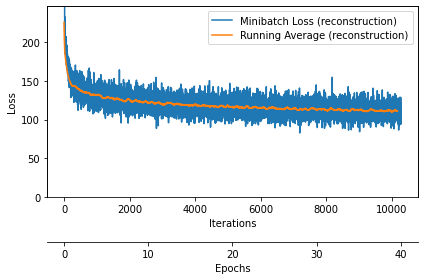

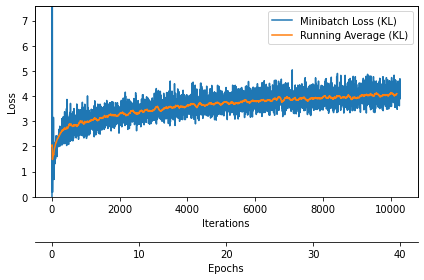

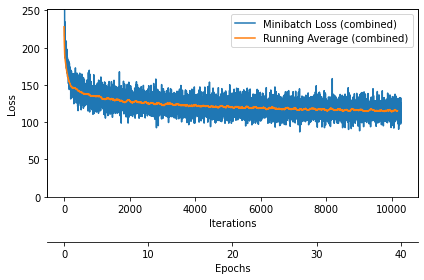

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


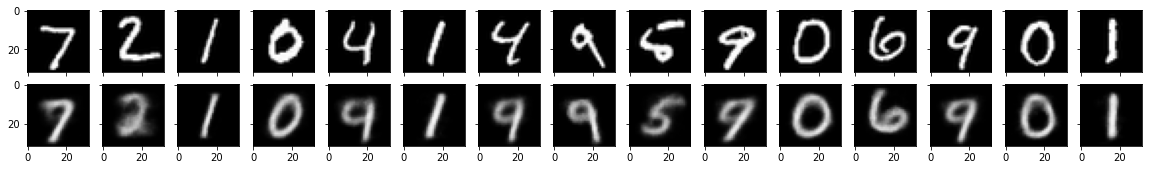

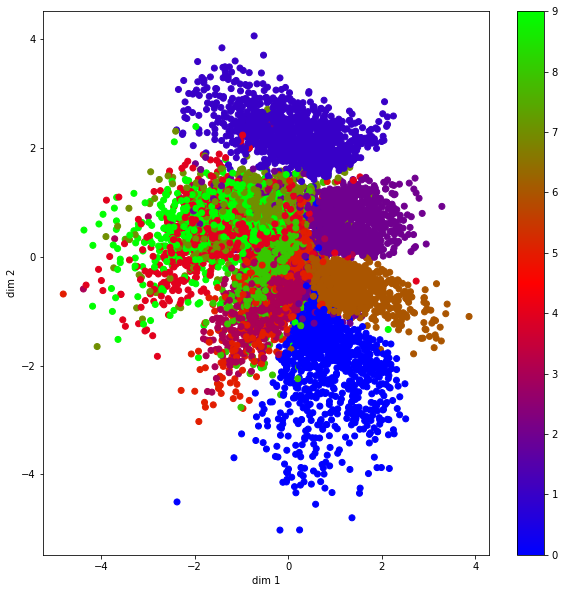

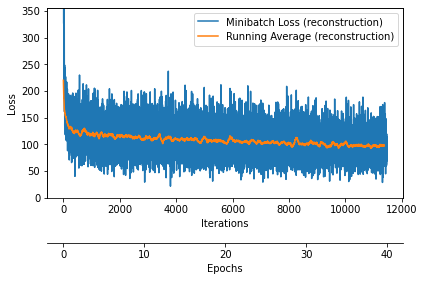

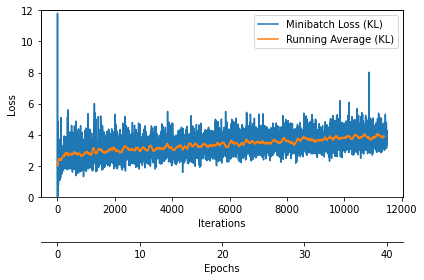

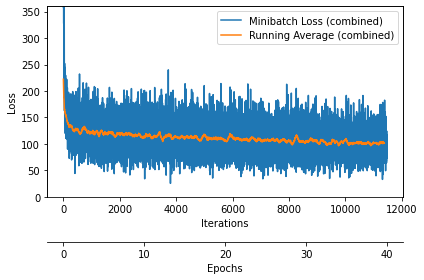

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


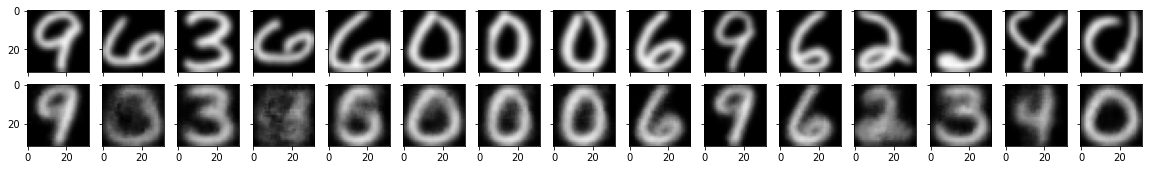

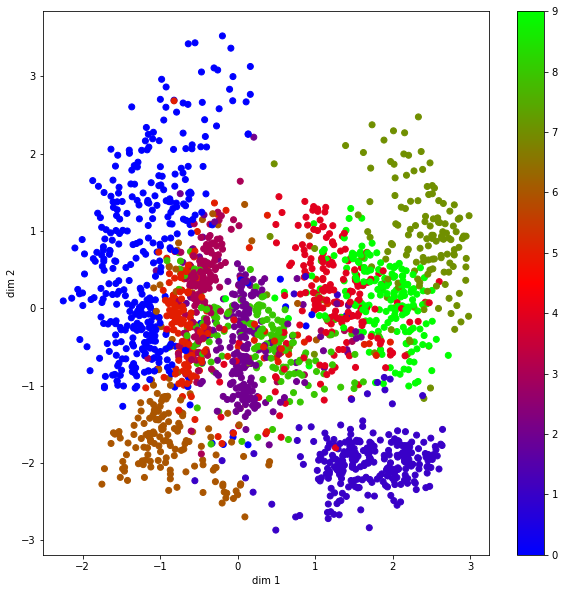

In [15]:
for name in data_names:
    plot_training_loss(log_dict[name]['train_reconstruction_loss_per_batch'], epochs, custom_label=" (reconstruction)")
    plot_training_loss(log_dict[name]['train_kl_loss_per_batch'], epochs, custom_label=" (KL)")
    plot_training_loss(log_dict[name]['train_combined_loss_per_batch'], epochs, custom_label=" (combined)")
    plt.show()
    
    train_set = mapfunc[name](split='test')
    plot_generated_images(dataset=train_set, model=vae[name], device=DEVICE)
    plot_2d_latent_space(model=vae[name], num_cls=10, data_set=train_set)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split

knn_clf = {}

for name in data_names:
    print(f'training knn with {name}')
    data_set = mapfunc[name](split='test')
    train_size = int(len(data_set)*0.7)
    test_size = len(data_set) - train_size
    train_set, test_set = random_split(data_set, [train_size, test_size], generator=torch.Generator().manual_seed(42))

    _, latent_data, classes = embed_img(vae[name], train_set, DEVICE)
    latent_data = latent_data[:, 0, :]
    latent_data, classes = latent_data.to('cpu').numpy(), classes.to('cpu').numpy()
    knn_clf[name] = KNeighborsClassifier(n_neighbors=3)
    knn_clf[name].fit(latent_data, classes)
    y_pred = knn_clf[name].predict(latent_data)
    print(accuracy_score(classes, y_pred))

training knn with mnist


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.7937142857142857
training knn with usps


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8205128205128205


In [17]:
distr_dataset = {}
for name in data_names:
    data_set = mapfunc[name](split='test')
    _, latent_data, classes = embed_img(vae[name], data_set, DEVICE)
    latent_data = torch.permute(latent_data, [1, 2, 0])
    print(latent_data.size())
    distr_dataset[name] = []
    for i in range(latent_dim):
        std_mean = torch.std_mean(latent_data[0, i, :], unbiased=True)
        distr_dataset[name].append(std_mean)
        
    print(latent_data.size())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([2, 2, 10000])
torch.Size([2, 2, 10000])
torch.Size([2, 2, 2007])
torch.Size([2, 2, 2007])


In [18]:
import random

def calculate_distri(name):
    ori = [torch.empty([0, 3, 32, 32])]*10
    latent = [torch.empty([0, latent_dim])]*10

    ori_imgs, latent_data, classes = embed_img(model=vae[name], data_set=train_set, device=DEVICE)
    #print(ori_imgs.size())
    latent_data, classes = latent_data[:, 0, :].cpu(), classes.type(torch.int32)

    for i in range(ori_imgs.size(0)):
        ori[classes[i].item()] = torch.cat([
            ori[classes[i].item()],
            torch.unsqueeze(ori_imgs[i], 0)
        ])
        latent[classes[i].item()] = torch.cat([
            latent[classes[i].item()], 
            torch.unsqueeze(latent_data[i], 0)
        ])

    #for i in range(10):
        #print(ori[i].size(), latent[i].size())

    distri = []
    for i in range(10):
        if latent[i].size(0) <= 0:
            distri.append(None)
        else: distri.append(torch.std_mean(latent[i], dim=0))
    
    return distri

def generate_data(name, num_sample):
    distri = calculate_distri(name)
    generated_data = torch.empty([0, 3, 32, 32])
    label_data = []
    bs = 10
    while generated_data.size(0) < num_sample:
        for i in range(10):
            if generated_data.size(0) >= num_sample:
                break
                
            if distri[i] == None:
                continue
                
            count = 0;
            sample_vector = torch.empty([bs, latent_dim])
            while count < bs:
                sample_vector[count] = torch.normal(
                    std=distri[i][0], 
                    mean=distri[i][1]
                )
                pred_label = knn_clf[name].predict([sample_vector[count].numpy()])
                if int(pred_label[0]) == i:
                    count += 1
                    label_data.append(i)

            sample_vector = sample_vector.to(DEVICE).type(torch.float32)
            decoded_example = vae[name].decoder(sample_vector).detach().cpu()
            generated_data = torch.cat([
                generated_data, decoded_example
            ])
            #imgshow(decoded_example, lb)
    return generated_data, torch.tensor(label_data)

In [19]:
OUTPATH = '/kaggle/working/'
data_name = 'usps'
for i in range(4): 
    x, y = generate_data(data_name, 5000)
    fname = f'{data_name}_fake_{i}.pkl'
    with open(OUTPATH + fname, 'wb') as f:
        pickle.dump([x, y], f)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: 

torch.Size([5000, 3, 32, 32]) torch.Size([5000])


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0, time 1.57, cls_loss 0.3784, train_acc: 84.75
epoch 1, time 1.36, cls_loss 0.2686, train_acc: 83.16
epoch 2, time 1.38, cls_loss 0.2378, train_acc: 85.30
epoch 3, time 1.37, cls_loss 0.2150, train_acc: 84.01
epoch 4, time 1.36, cls_loss 0.2051, train_acc: 83.41
epoch 5, time 1.36, cls_loss 0.1990, train_acc: 83.66
epoch 6, time 1.55, cls_loss 0.1933, train_acc: 83.66
epoch 7, time 1.36, cls_loss 0.1776, train_acc: 83.56
epoch 8, time 1.37, cls_loss 0.1842, train_acc: 83.01
epoch 9, time 1.36, cls_loss 0.1748, train_acc: 83.51
torch.Size([5000, 3, 32, 32]) torch.Size([5000])


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0, time 1.39, cls_loss 0.2271, train_acc: 83.31
epoch 1, time 1.38, cls_loss 0.1959, train_acc: 82.56
epoch 2, time 1.37, cls_loss 0.1761, train_acc: 83.56
epoch 3, time 1.45, cls_loss 0.1667, train_acc: 82.51
epoch 4, time 1.49, cls_loss 0.1570, train_acc: 81.91
epoch 5, time 1.38, cls_loss 0.1520, train_acc: 82.81
epoch 6, time 1.37, cls_loss 0.1494, train_acc: 82.26
epoch 7, time 1.35, cls_loss 0.1488, train_acc: 82.36
epoch 8, time 1.37, cls_loss 0.1431, train_acc: 82.51
epoch 9, time 1.37, cls_loss 0.1403, train_acc: 81.56
torch.Size([5000, 3, 32, 32]) torch.Size([5000])


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0, time 1.38, cls_loss 0.1916, train_acc: 81.42
epoch 1, time 1.56, cls_loss 0.1557, train_acc: 82.26
epoch 2, time 1.54, cls_loss 0.1502, train_acc: 81.46
epoch 3, time 1.81, cls_loss 0.1353, train_acc: 81.27
epoch 4, time 1.36, cls_loss 0.1334, train_acc: 80.37
epoch 5, time 1.36, cls_loss 0.1362, train_acc: 81.22
epoch 6, time 1.38, cls_loss 0.1361, train_acc: 81.81
epoch 7, time 1.38, cls_loss 0.1289, train_acc: 80.42
epoch 8, time 1.36, cls_loss 0.1373, train_acc: 81.07
epoch 9, time 1.55, cls_loss 0.1220, train_acc: 80.82
torch.Size([5000, 3, 32, 32]) torch.Size([5000])


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0, time 1.41, cls_loss 0.1856, train_acc: 80.87
epoch 1, time 1.38, cls_loss 0.1441, train_acc: 81.56
epoch 2, time 1.38, cls_loss 0.1278, train_acc: 81.32
epoch 3, time 1.40, cls_loss 0.1285, train_acc: 81.22
epoch 4, time 1.38, cls_loss 0.1167, train_acc: 80.42
epoch 5, time 1.42, cls_loss 0.1187, train_acc: 81.61
epoch 6, time 1.55, cls_loss 0.1214, train_acc: 81.02
epoch 7, time 1.48, cls_loss 0.1081, train_acc: 81.32
epoch 8, time 1.38, cls_loss 0.1070, train_acc: 79.77
epoch 9, time 1.39, cls_loss 0.1069, train_acc: 79.92


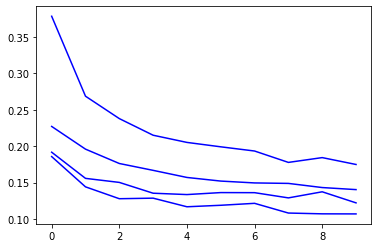

In [20]:
data_name = 'usps'
for i in range(4):
    with open(os.path.join(OUTPATH, f'{data_name}_fake_{i}.pkl'), 'rb') as f:
        x, y = pickle.load(f)
        print(x.size(), y.size())
        data_fake = TensorDataset(x, y)
    train_task_model(cls_net, data=data_fake, name=data_name, epochs=10)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


   mnist       usps
0  75.72  79.920279


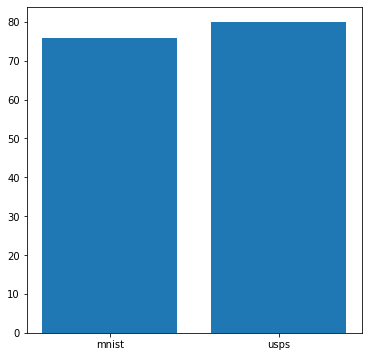

In [21]:
evaluate_digit(cls_net, name_test='usps')